In [2]:
import numpy as np
import nibabel as nib 
import os 
import pandas as pd
from utils.utils import * 
from utils.flips import get_prefered_xy
import math
import matplotlib.pyplot as plt

In [3]:
rois_long = {'V1v': 1, 'V1d': 2, 'V2v': 3, 'V2d': 4, 'V3v': 5, 'V3d': 6, 'hV4': 7, 'VO-1': 8,
 'VO-2': 9, 'PHC-1': 10, 'PHC-2': 11, 'LO-1': 12, 'LO-2': 13, 'TO-1': 14, 'TO-2': 15
}
sior_long = {v: k for k,v in rois_long.items()}
to_reduce = {'V1v': 'V1', 'V1d': 'V1', 'V2v': 'V2', 'V2d': 'V2', 'V3v': 'V3', 'V3d': 'V3'}
sior = {v: k for k,v in rois.items()}

In [4]:
cos_sin = get_prefered_xy(subj_list, sessions, fetch_conds=False) # save that and open it matlab 


(907,)


In [5]:
cos_sin  #Y's sould probably be flipped

array([[ 1.        ,  0.        ],
       [ 0.6541633 ,  0.75635332],
       [ 0.36456779,  0.93117684],
       [ 0.53622597,  0.84407449],
       [ 0.68344992, -0.72999746],
       [ 0.72568947,  0.68802243],
       [ 0.427239  ,  0.90413874],
       [-0.29617682,  0.95513314]])

In [18]:
"""
the code is currently used to get the best roi on the cortical surface  ==== I should parameterize it 
"""
models_subs = {}
models = ['oself']
columns = ["x0", "y0", "sigma", "slope", "intercept", "test_var_explained", "var_explained", "mds_ecc", "mds_ang", "roi", "fit_with"]
columns = ["x0", "y0", "sigma", "slope", "intercept", "test_var_explained", "var_explained", "mds_ecc", "mds_ang" ,"roi", "best_roi"]
model_study = 'woself'
model_study = 'best_roi'
mode = "train"
rotated = True

#cos_sin = get_prefered_xy(subj_list) # save that and open it matlab 
#print(cos_sin)


for i, sub in enumerate(subj_list):
    models_subs[sub] = {}
    noise_ceilling_file = os.path.join(noise_dir, f'{sub}_noise_ceilling_all_vox.npy')
    noise_ceilling = np.load(noise_ceilling_file, allow_pickle=True)
    for m in models:
        if m == 'best_roi':
            m_file = os.path.join(models_dir, f'best_fits_{m}_{sub}_{mode}.npy')
        else: 
            m_file = os.path.join(models_dir, f'best_fits_{m}_{sub}_{mode}.npy')
        models_subs[sub][m] = pd.DataFrame(np.load(m_file, allow_pickle=True), columns=columns)
        models_subs[sub][m][columns[:-2]] = models_subs[sub][m][columns[:-2]].astype(np.float32)
        models_subs[sub][m]['noise_ceilling'] = noise_ceilling
        models_subs[sub][m]['voxel_performance'] = models_subs[sub][m]["test_var_explained"] / models_subs[sub][m]['noise_ceilling']
        # this should be okay 
        models_subs[sub][m]['x0_prefered'] = models_subs[sub][m]['x0'] * cos_sin[i, 0]-models_subs[sub][m]['y0'] * cos_sin[i, 1] # the mds have different dimension -> so problem 
        models_subs[sub][m]['y0_prefered'] = models_subs[sub][m]['x0'] * cos_sin[i, 1]+models_subs[sub][m]['y0'] * cos_sin[i, 0]
       # models_subs[sub][m]['distance'] = np.sqrt(models_subs[sub][m]['x0']**2 + models_subs[sub][m]['y0']**2)
   #     models_subs[sub][m]['distance_prefered'] = np.sqrt(models_subs[sub][m]['x0_prefered']**2 + models_subs[sub][m]['y0_prefered']**2)
    sub_m_study = models_subs[sub][model_study]

hier_index = pd.MultiIndex.from_arrays(
    [
        np.tile(list(rois.keys()), len(models_subs)),
        np.repeat(list(models_subs.keys()), len(rois.keys())),
    ],
    names =["roi", "sub"]
)
models_subs["subj01"][model_study]["test_var_explained"]

# check distribution of values in VO-1s for common conditions 

#plt.plot(models_subs["subj08"][model_study]["voxel_performance"]) #? 
models_subs

KeyError: 'best_roi'

In [19]:
models_subs

{'subj01': {'oself':              x0        y0     sigma      slope  intercept  test_var_explained  \
  0      0.372320 -0.623904  5.088526  20.269579 -20.049505            0.000683   
  1      0.418216 -0.594909  6.371511  27.195335 -26.994867           -0.000804   
  2      0.502180 -0.546803  5.603322  17.069893 -16.888922           -0.002069   
  3      0.349324 -0.618380  6.187158  30.486681 -30.267786           -0.001290   
  4      0.331933 -0.591473  5.677624  26.163538 -25.946020           -0.002995   
  ...         ...       ...       ...        ...        ...                 ...   
  33792 -0.168001  1.050000  5.891155  61.754356 -61.342781            0.024231   
  33793 -0.109479 -1.050000  4.638591  22.051933 -21.820461            0.005299   
  33794 -0.283194  0.284295  5.647521  21.789379 -21.611290            0.008925   
  33795 -0.196283 -0.806605  3.401744  10.854861 -10.626771            0.006272   
  33796 -0.315528 -0.149364  4.732632  15.733027 -15.540269         

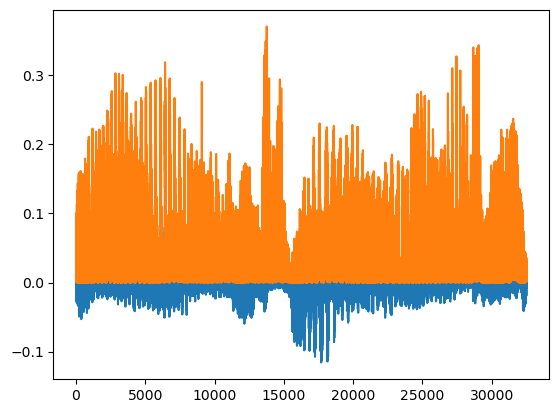

In [9]:
plt.plot(models_subs["subj08"][model_study]["test_var_explained"])
plt.plot(models_subs["subj08"][model_study]["noise_ceilling"])
plt.show()

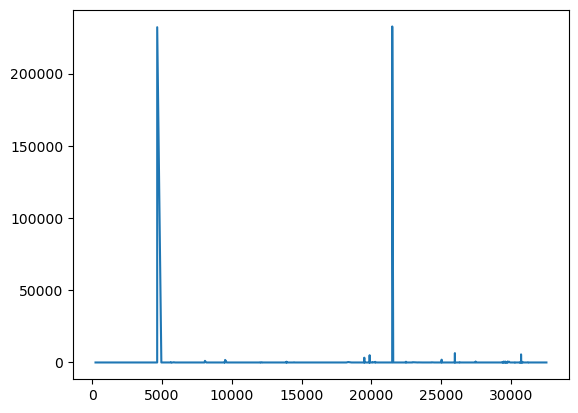

In [12]:
plt.plot(models_subs["subj08"][model_study]["voxel_performance"][models_subs["subj08"][model_study]["voxel_performance"] > 1])

In [20]:
hemis = ['lh', 'rh']
fields = columns
fields.append('x0_prefered')
fields.append('y0_prefered')
fields.append('noise_ceilling')
fields.append('voxel_performance')
if rotated:
    rotation = "rotated"
if not rotated: 
    rotation = "notrotated"


for model in models:
    for sub, sessions in subjects_sessions.values():
        m = models_subs[sub][model]
        print(f'------ EXPORTING MODEL FOR {sub}')
        for f in fields:
            print(f'\t{f}')
            s = -1
            for hemi in hemis:
                print(f'\t\t{hemi}')
                
                if sub == 'subj06' or sub == 'subj08':
                    maskdata_long_file = os.path.join(data_dir, 'mask', sub, f'{hemi}.{sub}.nans.testrois.mgz')
                else:
                    maskdata_long_file = os.path.join(data_dir, 'mask', sub, f'{hemi}.{sub}.testrois.mgz')
                maskdata_long = nib.load(maskdata_long_file).get_fdata().squeeze()
              #  print(maskdata_long.shape)
        
                maskdata_file = os.path.join(data_dir, 'mask', sub, f'{hemi}.short.reduced.{sub}.testrois.npy')
                maskdata = np.load(maskdata_file, allow_pickle=True).astype(int)

                data_out_file = os.path.join(results_dir, sub, f'{hemi}.{model}.{f}.{rotation}.mgz')
                label_out_file = os.path.join(label_dir,'freesurfer', sub, 'label', f'{hemi}.{model}.{f}.{rotation}.mgz') # annoying but necessary for matlab output
                if os.path.exists(data_out_file):
                    pass
                data_out = np.zeros(maskdata_long.shape)
             
                wrongs = []
                for i in range(maskdata_long.shape[0]):
                    voxel = int(maskdata_long[i])
                    if voxel==0 or voxel > 15:
                        continue
                    s += 1
                    if sior_long[voxel] in to_reduce.keys():
                        roi = rois[to_reduce[sior_long[voxel]]]
                    else:
                        roi = rois[sior_long[voxel]]
                  #  roi = rois[sior[voxel]]
                    # prove that the order is maintained
                    if roi != rois[m.iloc[s].roi]:
                        print(f'{i}: {roi} != {rois[m.iloc[s].roi]}')
                        wrongs.append(i)
                    if f in ['roi', 'best_roi']:
                        data_out[i] = rois[m.iloc[s][f]]
                    elif f == 'mds_ang':
                        data_out[i] = math.degrees(m.iloc[s][f]) + 180
                    elif f == 'intercept':
                        data_out[i] = m.iloc[s][f] + abs(m[f].min()) + 1e-08
                    elif f in ['x0', 'y0', 'x0_prefered', 'y0_prefered']:
                        data_out[i] = m.iloc[s][f] + 1.1
                    elif f in ['var_explained', 'test_var_explained']:
                        data_out[i] = m.iloc[s][f] + 1 # Add 1 for the variance explain, so we can still mask the non relevant value and plot the "negative" variance
                    elif f == 'voxel_performance':
                        data_out[i] = m.iloc[s][f] + 1
                    else:
                        data_out[i] = m.iloc[s][f]  
                img = nib.Nifti1Image(np.expand_dims(data_out, axis=(1, 2)), np.eye(4))

                nib.loadsave.save(img, data_out_file)
                nib.loadsave.save(img, label_out_file)
                if f == 'mds_ang':
                    for ang in [45, 90, 135, 180, 225, 270, 305]:
                        data_out_file = os.path.join(results_dir, sub, f'{hemi}.{model}.f.{str(ang)}.{rotation}.mgz')
                        label_out_file = os.path.join(label_dir, 'freesurfer', sub, 'label', f'{hemi}.{model}.{f}.{str(ang)}.{rotation}.mgz')
                        data_out_ang = np.copy(data_out)
                        data_out_ang[data_out != 0] += ang
                        data_out_ang = data_out_ang % 360
                        img = nib.Nifti1Image(np.expand_dims(data_out_ang, axis = (1, 2)), np.eye(4))
                        nib.loadsave.save(img, data_out_file)
                        nib.loadsave.save(img, label_out_file)


print('end')
                        
            

------ EXPORTING MODEL FOR subj01
	x0
		lh


/home/harveylab/miniconda3/envs/thesis/lib/python3.10/site-packages/nibabel/spatialimages.py:558: UserWarning: Using large vector Freesurfer hack; header will not be compatible with SPM or FSL
  hdr.set_data_shape(shape)


		rh
	y0
		lh
		rh
	sigma
		lh
		rh
	slope
		lh
		rh
	intercept
		lh
		rh
	test_var_explained
		lh
		rh
	var_explained
		lh
		rh
	mds_ecc
		lh
		rh
	mds_ang
		lh
		rh
	roi
		lh
		rh
	best_roi
		lh
		rh
	x0_prefered
		lh
		rh
	y0_prefered
		lh
		rh
	noise_ceilling
		lh
		rh
	voxel_performance
		lh
		rh


KeyError: 'subj02'